# Digital Image Processing - coin detection

*author*: Rafał Lelito


Please select file form **sample_images** folder and then assign it to **sourceImage** variable.

### Functions displaying images

In [3]:
import matplotlib.pyplot as plt

# displaying images next to each other
def show2imgs(im1, im2, title1 = '1st image', title2 = '2nd image', size = (17,17)):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=size)
    ax1.imshow(im1, cmap = 'gray')
    ax1.axis()
    ax1.set_title(title1)

    ax2.imshow(im2, cmap = 'gray')
    ax2.axis()
    ax2.set_title(title2)
    plt.show()

# displaying one image
def showimg(img, title = 'Image', size = (10,10)):
    plt.figure(figsize = size)
    plt.title(title)
    plt.imshow(img, cmap = "gray")
    plt.axis()
    plt.show()

### Loading image and initial preparations 

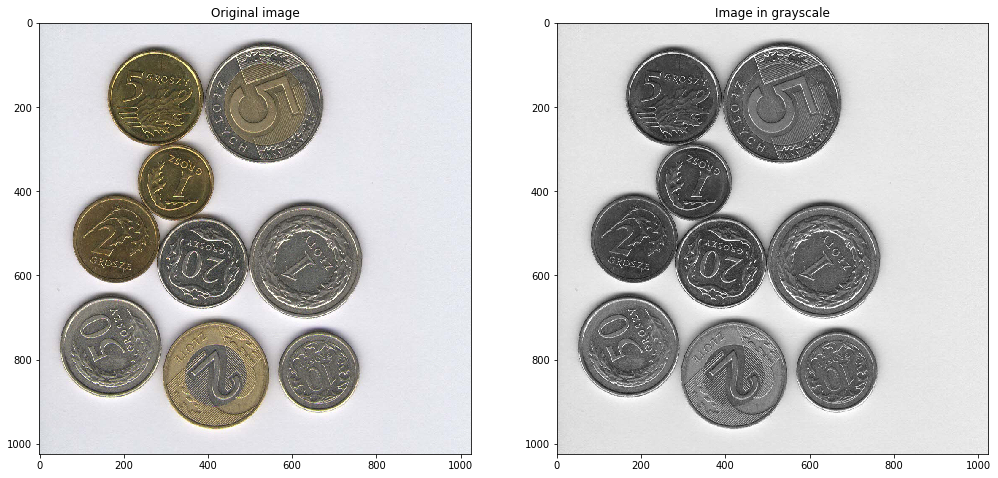

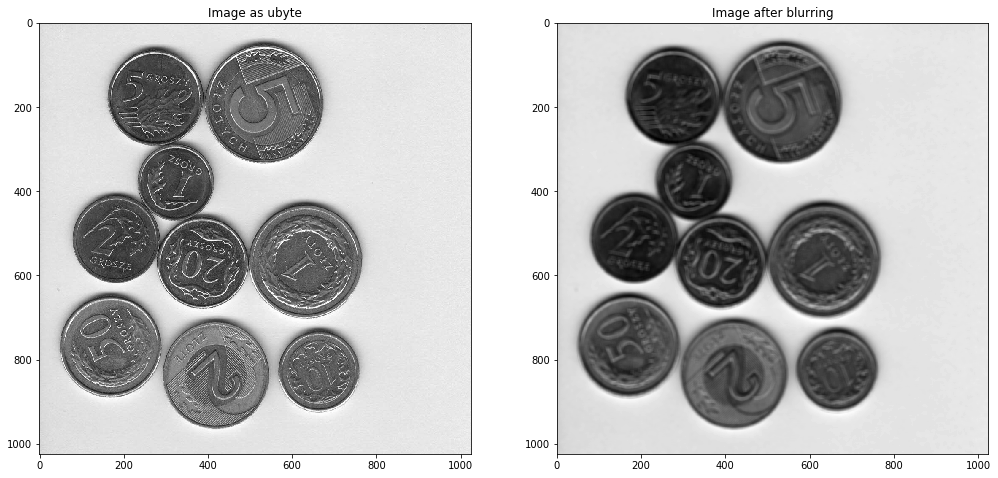

In [4]:
sourceImage = 'coins_23.jpg'


from skimage import io, color, img_as_ubyte
import cv2
import warnings
warnings.filterwarnings('ignore')

image = io.imread('sample_images/' + sourceImage)
imageGray = color.rgb2gray(image)
imageUbyte = img_as_ubyte(imageGray)
imageBlur = cv2.blur(imageUbyte, (9,9))

show2imgs(image, imageGray, "Original image", "Image in grayscale")
show2imgs(imageUbyte, imageBlur, "Image as ubyte", "Image after blurring")

### Comparing results of binary conversion

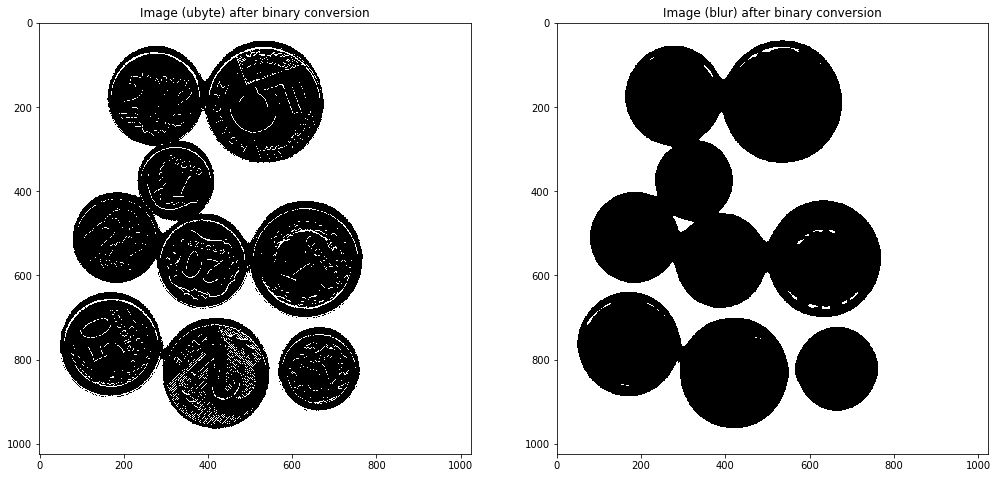

In [5]:
import cv2

th = 78
th, imageBinaryBlur = cv2.threshold(imageBlur, thresh = th, maxval = 255, type = cv2.THRESH_OTSU)
th, imageBinaryUbyte = cv2.threshold(imageUbyte, thresh = th, maxval = 255, type = cv2.THRESH_OTSU)

show2imgs(imageBinaryUbyte, imageBinaryBlur, "Image (ubyte) after binary conversion", "Image (blur) after binary conversion")

## Image tranistion to split coins

### Morphology operations: opening and dilation

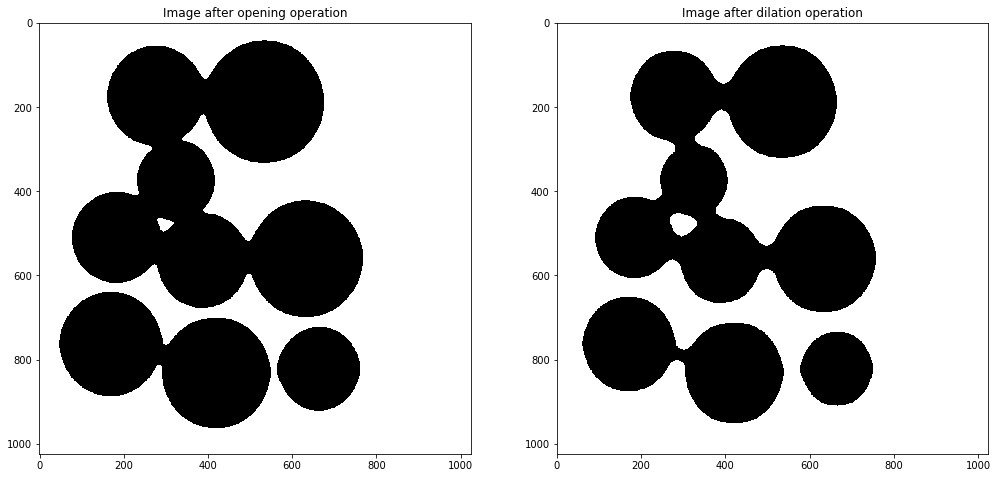

In [6]:
import numpy as np
import cv2

kernelEllipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))

imageOpening = cv2.morphologyEx(imageBinaryBlur, cv2.MORPH_OPEN, kernel = kernelEllipse, iterations = 2)
imageDilate = cv2.morphologyEx(imageOpening, cv2.MORPH_DILATE, kernel = kernelEllipse, iterations = 4)

show2imgs(imageOpening, imageDilate, "Image after opening operation", "Image after dilation operation")

### Operations: color inversion, distance transform

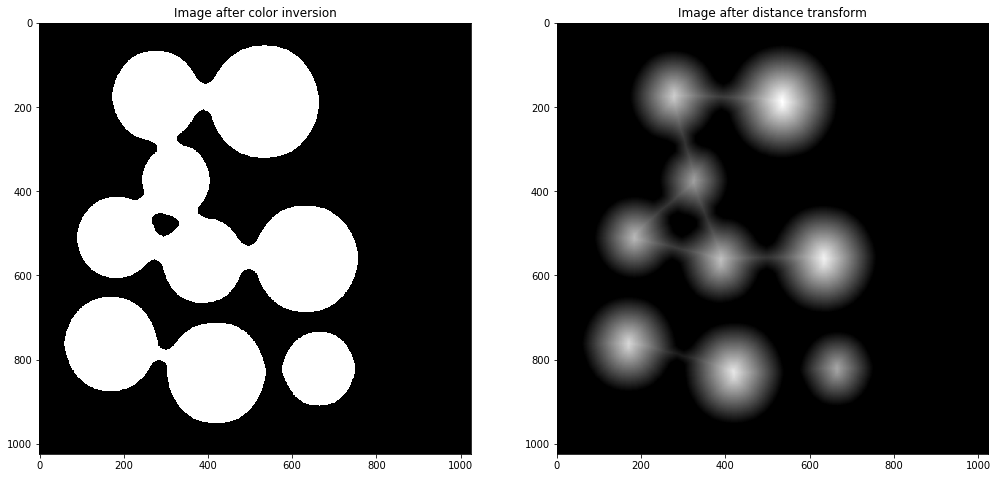

In [7]:
imageInvert = cv2.bitwise_not(imageDilate)
imageDistanceTransform = cv2.distanceTransform(imageInvert,cv2.DIST_L2,5)

show2imgs(imageInvert, imageDistanceTransform, "Image after color inversion", "Image after distance transform")

### Searching for certain foreground of coin and dilation operation

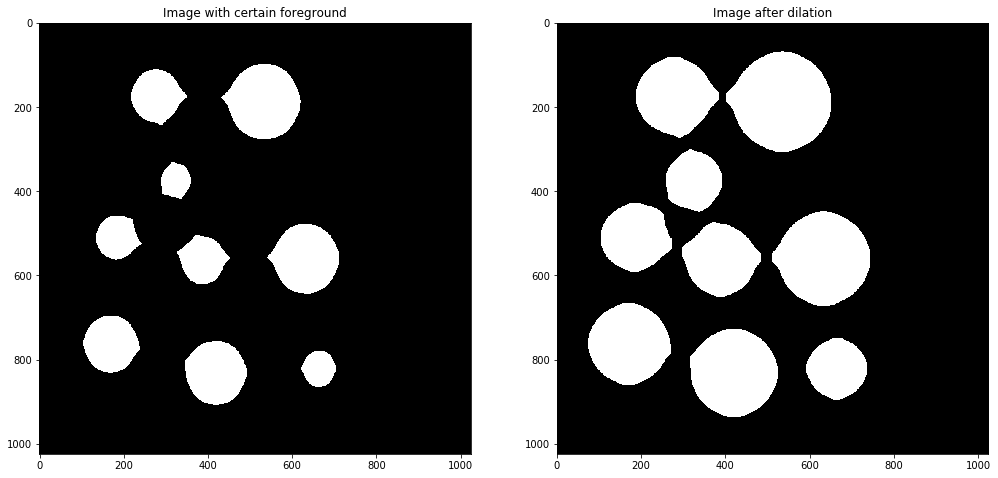

In [8]:
_, certainForeground = cv2.threshold(imageDistanceTransform, thresh=0.35*imageDistanceTransform.max(), maxval=255, type=0)
certainForegroundU8 = np.uint8(certainForeground)
imageCore = cv2.morphologyEx(certainForegroundU8, cv2.MORPH_DILATE, kernel = kernelEllipse, iterations = 10)

show2imgs(certainForeground, imageCore, "Image with certain foreground", "Image after dilation")

### Operations: searching for edge of coins, merging them with image and removing small objects

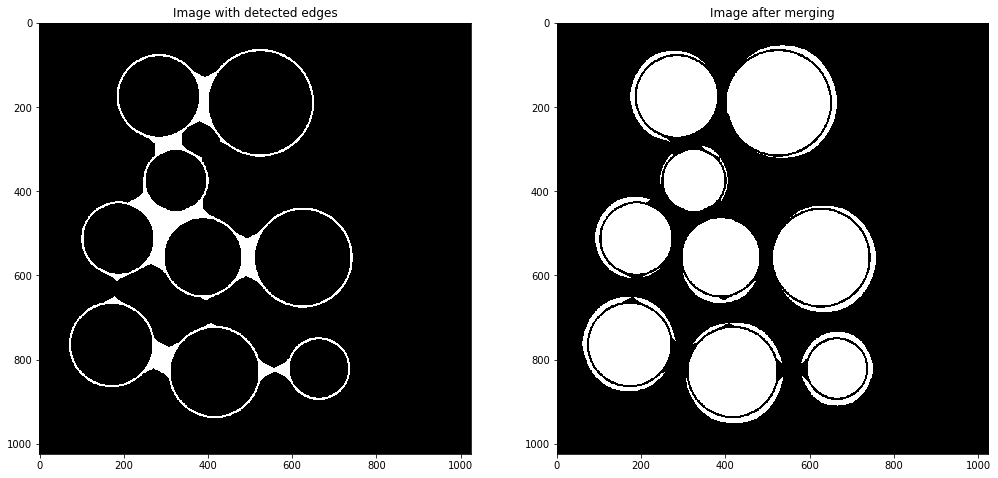

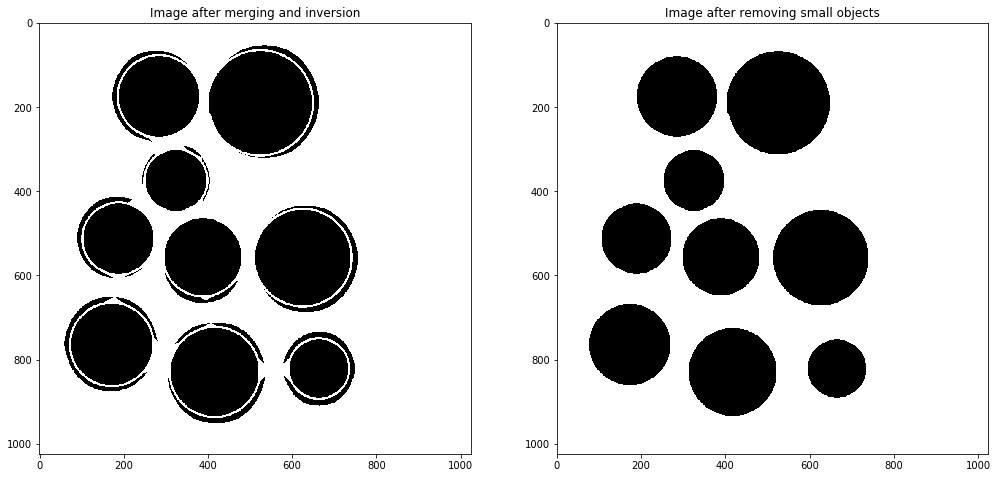

In [9]:
_, objectContours, _ = cv2.findContours(imageCore, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
imageContours = np.zeros_like(imageInvert)
for i in range(len(objectContours)):
    objectCircle = objectContours[i]
    (y, x), objectRadius = cv2.minEnclosingCircle(objectCircle)
    objectCenter = (int(y), int(x))
    objectRadius = int(objectRadius)
    cv2.circle(imageContours, objectCenter, objectRadius, 255, 3)

imageContours = cv2.morphologyEx(imageContours, cv2.MORPH_CLOSE, kernel = kernelEllipse, iterations = 12)
imageConnected = cv2.subtract(imageInvert, imageContours)

from skimage import morphology
imageConnectedInvert = cv2.bitwise_not(imageConnected)
imageFinal = morphology.remove_small_holes(imageConnectedInvert, min_size = 10000)

show2imgs(imageContours, imageConnected, "Image with detected edges", "Image after merging")
show2imgs(imageConnectedInvert, imageFinal, "Image after merging and inversion", "Image after removing small objects")

## Region splitting segmentation

In [10]:
import numpy as np

# spliting function
def mySplit(img, index, yStart, yEnd, xStart, xEnd, obj):
    # checking if all elements in the area are the same
    checkAllTheSame = 1
    for y in range(yStart, yEnd):
        for x in range(xStart, xEnd):
            if img[y][x] != img[yStart][xStart]:
                checkAllTheSame = 0
                break
        if checkAllTheSame == 0:
            break
                
    if checkAllTheSame == 1:
        indexTab = []

        # checking top edge
        if yStart > 0:
            for x in range(xStart, xEnd):
                if img[yStart-1][x] == img[yStart][xStart]:
                    indexTab.append(index[yStart-1][x])
        # checking left edge
        if xStart > 0:
            for y in range(yStart, yEnd):
                if img[y][xStart-1] == img[yStart][xStart]:
                    indexTab.append(index[y][xStart-1])

        # list of all indexes without duplicates in surroundings
        indexTab = list(set(indexTab))
        indexTab.sort()

        # assigning proper index value
        if len(indexTab) == 0:
            indexNow = obj
            obj +=1
        if len(indexTab) >= 1:
            indexNow = indexTab[0]

        # index assingnment
        for y in range(yStart, yEnd):
            for x in range(xStart, xEnd):
                index[y][x] = indexNow

        # merging regions
        if len(indexTab) > 1:
            for y in range(img.shape[0]):
                for x in range(img.shape[1]):
                    if index[y][x] == 0:
                        break
                    if index[y][x] in indexTab[1:]:
                        index[y][x] = indexNow

    # spliting an area when the region is not homogeneous
    else:
        yNew = ((yEnd-yStart)//2) + yStart
        xNew = ((xEnd-xStart)//2) + xStart

        R1, obj = mySplit(img, index, yStart, yNew, xStart, xNew, obj)
        R2, obj = mySplit(img, index, yStart, yNew, xNew, xEnd, obj)
        R3, obj = mySplit(img, index, yNew, yEnd, xStart, xNew, obj)
        R4, obj = mySplit(img, index, yNew, yEnd, xNew, xEnd, obj)

    return index, obj

# R1 | R2
# -------
# R3 | R4


# main function
def mySegmentation(img):
    index = np.zeros((img.shape[0],img.shape[1]), dtype=int)

    index, objectNumber = mySplit(img, index, yStart=0, yEnd=img.shape[0], xStart=0, xEnd=img.shape[1], obj=1)

    # countiong regions
    objectIdList = []
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if index[y][x] not in objectIdList:
                objectIdList.append(index[y][x])

    objectIdList.sort()
    objectNumber = len(objectIdList)

    return index, objectNumber, objectIdList

### Launching segmentation function

In [15]:
import time
t0 = time.time()

imageIndex, objectNumber, objectIdList = mySegmentation(imageFinal)
tEnd = int(time.time()-t0)
print("\nRunning time:", tEnd, "seconds")


Running time: 364 seconds


In [16]:
print("Segmentation results\n")
print("Number of objects (including background):", objectNumber)
print("Object id's:", objectIdList)

Segmentation results

Number of objects (including background): 10
Object id's: [1, 2, 46, 129, 132, 230, 318, 389, 493, 655]


### Collecting data about objects and storing them in list of dictionaries

In [19]:
# additions functions

def showimgColored(img, title="Obraz", size = (10, 10)):
    import matplotlib.pyplot as plt
    plt.figure(figsize = size)
    plt.title(title)
    plt.imshow(img, cmap = "hot")
    plt.axis()
    plt.show()

def transformId(img, number):
    newImg = np.zeros((img.shape[0],img.shape[1]), dtype=int)
    for i in range(1, number+1):
        for y in range(img.shape[0]):
            for x in range(img.shape[1]):
                if img[y][x] == objectsData[i]['id']:
                    newImg[y][x] = 255//number * i
    return newImg

def getFigure(labelledImage, objNumber):
    points = []
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                points.append((y,x))
    return points

Number of objects (with background) 10
ID:   1 	size: 790435
ID:   2 	size: 28533
ID:  46 	size: 46859
ID: 129 	size: 16315
ID: 132 	size: 21769
ID: 230 	size: 26169
ID: 318 	size: 40277
ID: 389 	size: 29081
ID: 493 	size: 34113
ID: 655 	size: 15025

Objects: 24.618244171142578 % of image


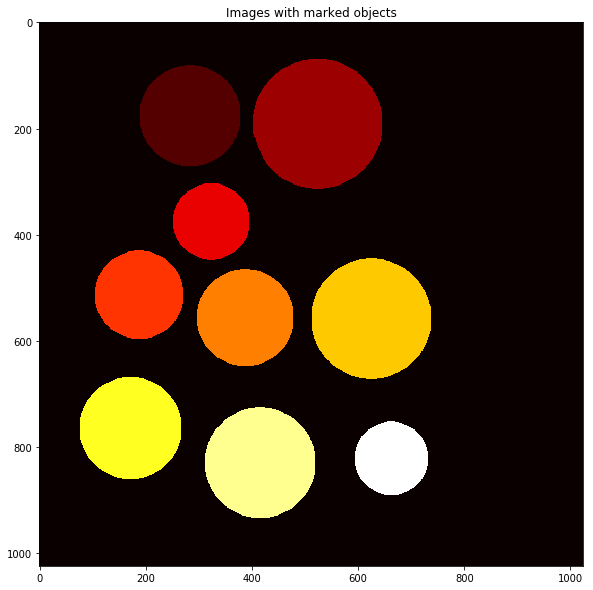

In [20]:
# list storing all data about objects in dictionary
objectsData = []

for i in objectIdList:
    area = getFigure(imageIndex, i)
    objectsData.append({'id': i, 'area': area, 'size':len(area)})

print("Number of objects (with background)", len(objectsData))
for o in objectsData:
    print("ID: %3d \tsize: %d" % (o['id'], o['size']))
print("\nObjects:", 100-(objectsData[0]['size']/(imageIndex.shape[0]*imageIndex.shape[0]) * 100), "% of image")

newImageIndex = transformId(imageIndex, objectNumber-1)
showimgColored(newImageIndex, "Images with marked objects")

### Function displaying objects by Id

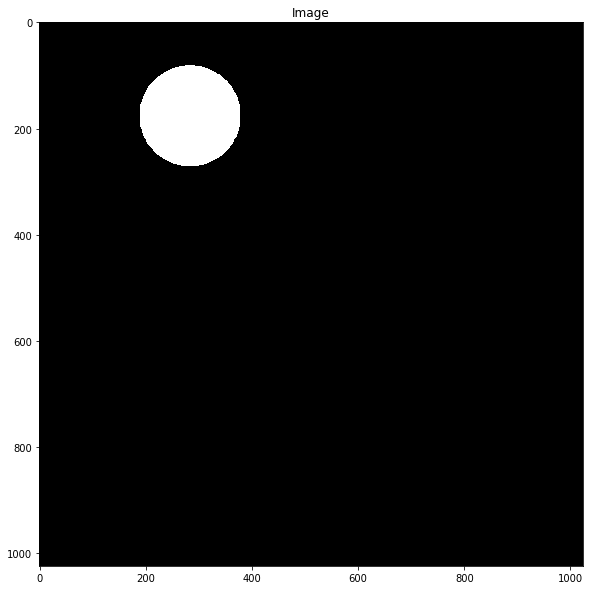

In [21]:
def showimgById(img, objId):
    newImageIndex = np.zeros((img.shape[0],img.shape[1]), dtype=int)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y][x] == objId:
                newImageIndex[y][x] = 1 #bialy
    showimg(newImageIndex)

showimgById(imageIndex, 2)

### Setting center of gravity / Computing factors: BlairBliss, Feret, Haralick

In [22]:
# functions

from scipy.spatial import distance
import math

def cog2(points):
    mx=0
    my=0
    for (y,x) in points:
        mx = mx + x
        my = my + y
    mx = mx//len(points)
    my = my//len(points)
    return (my, mx)

def computeBlairBliss(points):
    s = len(points)
    my,mx = cog2(points)
    r = 0
    for point in points:
         r = r + distance.euclidean(point,(my,mx))**2
    return s/(math.sqrt(2*math.pi*r))

def computeFeret(points):
    px = [x for (y,x) in points]
    py = [y for (y,x) in points]
    fx = max(px) - min(px)
    fy = max(py) - min(py)
    return float(fy)/float(fx)

def computeHaralick(center, contours):
    n = len(contours)
    mx, my = center
    d1 = 0
    d2 = 0
    for i in range(n):
        d1 += distance.euclidean((contours[i][0][1], contours[i][0][0]),(my,mx))
        d2 += (distance.euclidean((contours[i][0][1], contours[i][0][0]),(my,mx))**2 - 1)
    return math.sqrt((d1**2)/(n*d2))

#### Output

In [25]:
for o in objectsData[1:]:
    _, contours, _ = cv2.findContours(np.uint8(imageIndex==o['id']), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        o['contours'] = cnt
        x, y, w, h = cv2.boundingRect(cnt)
    o['position'] = (x, y, w, h)
    o['center'] = cog2(o['area'])
    
    BB = computeBlairBliss(o['area'])
    Feret = computeFeret(o['area'])
    Haral = computeHaralick(o['center'], o['contours'])
    print("ID: %3d \tCenter of gravity: (%d, %d) \tBlairBliss: %.8f \tFeret: %.8f \tHaralick: %.8f" 
          % (o['id'],o['center'][0],o['center'][1],BB,Feret,Haral))

ID:   2 	Center of gravity: (175, 284) 	BlairBliss: 0.99987197 	Feret: 1.01063830 	Haralick: 0.93459960
ID:  46 	Center of gravity: (190, 524) 	BlairBliss: 0.99990662 	Feret: 1.00826446 	Haralick: 0.98451842
ID: 129 	Center of gravity: (374, 323) 	BlairBliss: 0.99951316 	Feret: 1.01408451 	Haralick: 0.90256748
ID: 132 	Center of gravity: (513, 188) 	BlairBliss: 0.99995352 	Feret: 1.01219512 	Haralick: 0.99216742
ID: 230 	Center of gravity: (556, 388) 	BlairBliss: 0.99997616 	Feret: 1.01111111 	Haralick: 0.96863785
ID: 318 	Center of gravity: (558, 625) 	BlairBliss: 0.99998549 	Feret: 1.00892857 	Haralick: 0.90978747
ID: 389 	Center of gravity: (764, 172) 	BlairBliss: 0.99997980 	Feret: 1.01052632 	Haralick: 0.99677551
ID: 493 	Center of gravity: (829, 416) 	BlairBliss: 0.99998073 	Feret: 1.00970874 	Haralick: 0.99237394
ID: 655 	Center of gravity: (821, 663) 	BlairBliss: 0.99993031 	Feret: 1.01470588 	Haralick: 0.97861609


## Detecting nominal value of coins

In [26]:
# functions

import colorsys

# checking if selected value is in margin of error
def isIn(value, core, marginOfError):
    # increasing value if size of the object is checked
    if value > 1000:
        core *= 1000
        marginOfError *= 1000
    return ((core - marginOfError) <= value) and (value <= (core + marginOfError))

# checking an average HSV of the object
def averageHSV(img):
    average = img.mean(axis = 0).mean(axis = 0)
    h, s, v = colorsys.rgb_to_hsv(average[0] / 255, average[1] / 255, average[2] / 255)
    return (h * 360, s * 100, v * 100)

# function detecting coin value
def findValue(objectSize, objectHSV):
    # checking size and average saturation of the coin
    # coins with copper center have average hue greater than 20
    # coins with silver center have average hue less than 20
    if isIn(objectSize, 17, 2.5) and objectHSV[1] > 20:
        return 1
    elif isIn(objectSize, 17, 2.5) and objectHSV[1] < 20:
        return 10
    # it's hard to detect difference between 2 pln and 1 pln based on size and average saturation only
    # that's why there is also a condition to check hue
    elif objectHSV[1] < 20 and isIn(objectSize, 35.5, 3) and isIn(objectHSV[0], 39, 2):
        return 200
    elif objectHSV[1] < 20 and isIn(objectSize, 42.5, 5.5) and isIn(objectHSV[0], 43, 7):
        return 100
    elif isIn(objectSize, 30.5, 4.5) and objectHSV[1] > 20:
        return 5
    elif isIn(objectSize, 30.5, 4.5) and objectHSV[1] < 20:
        return 50
    elif isIn(objectSize, 24, 3) and objectHSV[1] > 20:
        return 2
    elif isIn(objectSize, 24, 3) and objectHSV[1] < 20:
        return 20
    if isIn(objectSize, 47.5, 5.5) and objectHSV[1] > 20:
        return 500
    else:
        return 0

### Final program output

In [28]:
sumOfCoins = 0

print("Data for all coins:")
for i in objectsData[1:]:
    size = 30
    coinCenterColor = image[i['center'][0]-size:i['center'][0]+size, i['center'][1]-size:i['center'][1]+size]
    coinCenterColorBlur = cv2.blur(coinCenterColor, (9, 9))
    objectCenterHSV = averageHSV(coinCenterColorBlur)
    coinValue = findValue(i['size'], objectCenterHSV)
    sumOfCoins = sumOfCoins + coinValue
    print("Id: %3d \tNominal value:" % (i['id']), coinValue/100)

# print("\n\nSUMA NOMINALOW MONET NA OBRAZKU: %.2f" % (sumOfCoins/100), "zł")
print("\n\nTOTAL VALUE OF COINS: %.2f" % (sumOfCoins/100), "PLN")

Data for all coins:
Id:   2 	Nominal value: 0.05
Id:  46 	Nominal value: 5.0
Id: 129 	Nominal value: 0.01
Id: 132 	Nominal value: 0.02
Id: 230 	Nominal value: 0.5
Id: 318 	Nominal value: 1.0
Id: 389 	Nominal value: 0.5
Id: 493 	Nominal value: 2.0
Id: 655 	Nominal value: 0.1


TOTAL VALUE OF COINS: 9.18 PLN
